In [1]:
import os
import datetime
import csv
import urllib.request
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import glob

## 指定気圧面データ

In [2]:
url="https://www.data.jma.go.jp/obd/stats/etrn/upper/view/hourly_usp.php?year=2021&month=8&day=15&hour=9&atm=&point=47778&view="

In [4]:
html=urllib.request.urlopen(url).read()
soup=BeautifulSoup(html)
trs=soup.find("table",{"class":"data2_s","id":"tablefix2"})

In [21]:
data={
    "Pressure":[],
    "height":[],
    "temperature":[],
    "RH":[],
    "wind_verocity":[],
    "wind_direction":[]
}

for tr in trs.find_all("tr")[1:]:
    tds=tr.find_all("td")
    data["Pressure"].append(tds[0].string)
    data["height"].append(tds[1].string)
    data["temperature"].append(tds[2].string)
    data["RH"].append(tds[3].string)
    data["wind_verocity"].append(tds[4].string)
    data["wind_direction"].append(tds[5].string)

In [23]:
df=pd.DataFrame(data)

In [24]:
for t in tds[0]:
    print(t.string)

5


In [25]:
df.replace("///",np.nan,inplace=True)

In [29]:
df2=df.astype("float")

## 観測元データ

In [31]:
url="https://www.data.jma.go.jp/obd/stats/etrn/upper/view/daily_uth.php?year=2021&month=8&day=15&hour=9&atm=&point=47778&view="

In [32]:
html=urllib.request.urlopen(url).read()
soup=BeautifulSoup(html)
trs=soup.find("table",{"class":"data2_s","id":"tablefix1"})

In [74]:
def get_upperobs(st_point=47778, date="2021-08-15",hour=9):
    date2=pd.to_datetime(date)
    year=date2.year
    month=date2.month
    day=date2.day
    url=f"https://www.data.jma.go.jp/obd/stats/etrn/upper/view/daily_uth.php?year={year}&month={month}&day={day}&hour={hour}&atm=&point={st_point}&view="
    html=urllib.request.urlopen(url).read()
    soup=BeautifulSoup(html)
    trs=soup.find("table",{"class":"data2_s","id":"tablefix1"})
    data={
        "Pressure":[],
        "height":[],
        "temperature":[],
        "RH":[],
        "flag":[],
    }
    for tr in trs.find_all("tr")[1:]:
        tds=tr.find_all("td")
        data["Pressure"].append(tds[0].string)
        data["height"].append(tds[1].string)
        data["temperature"].append(tds[2].string)
        data["RH"].append(tds[3].string)
        data["flag"].append(tds[4].string)

    df=pd.DataFrame(data)
    df.replace("///",np.nan,inplace=True)
    df2=df.astype({"Pressure":"float","height":"float","temperature":"float","RH":"float"})
    return df2

In [76]:
df2=get_upperobs(date="2021-11-02")
df2.head()

,Pressure,height,temperature,RH,flag
0,1008.4,70.0,19.3,67.0,特異点
1,1006.7,85.0,18.8,62.0,None
2,993.4,200.0,17.8,63.0,None
3,989.9,229.0,18.4,52.0,None
4,965.7,441.0,16.9,60.0,None


In [77]:
import matplotlib.pyplot as plt

## エマグラム

In [52]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd 
import pygrib 
import metpy
plt.style.use("ggplot")
from metpy import calc as mcal
from metpy.units import units

### 定数

In [62]:

## 定数
p=np.arange(1000,299,-1)
t=np.arange(120,-50,-1)
pp,tt=np.meshgrid(p,t)
press=units.Quantity(np.arange(1000,299,-50),"hPa")# セルシウス温度
temperature=units.Quantity(np.arange(120,-50,-1),"degC")
temperature2=units.Quantity(np.arange(230,400.1,10),"K")
pp2,tt2=np.meshgrid(press,temperature2) #絶対温度
#湿潤断熱線
moist=mcal.moist_lapse(pressure=press,temperature=temperature2[:,np.newaxis]).to("degC")
#乾燥断熱線
dry=mcal.dry_lapse(pressure=press,temperature=temperature2[:,np.newaxis]).to("degC")
## 飽和水蒸気圧
## tetens(1930)の式より
def e_saturation(Tcel):
    T=Tcel#ここセルシウス温度
    ganma=(7.50*T)/(T+237.3)
    e=6.1078*10**(ganma)
    return e
def w_saturation(Pd,Tcel):
    w_s=0.622*e_saturation(Tcel)/(Pd-e_saturation(Tcel))
    return w_s*1e3
## 露点温度
ws=w_saturation(pp,tt)

### 観測データ

In [98]:
df2=get_upperobs(date="2021-10-02")
met_t=units.Quantity(df2["temperature"].values,units="degC")
met_rh=units.Quantity(df2["RH"].values,units="%")
met_dew=mcal.dewpoint_from_relative_humidity(met_t,met_rh)
met_p=units.Quantity(df2["Pressure"].values,units="hPa")

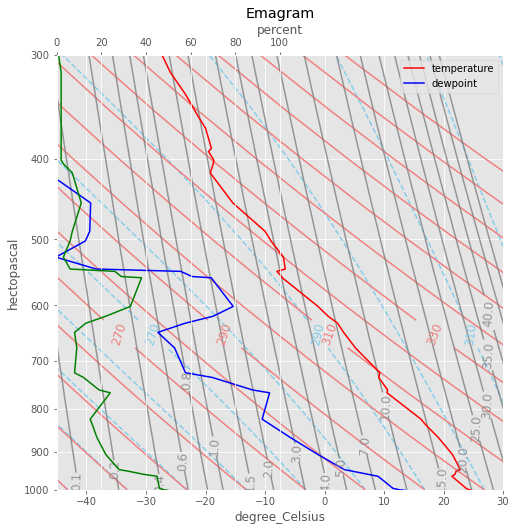

In [99]:
fig,ax=plt.subplots(figsize=(8,8),facecolor="w")
p=np.arange(1000,299,-50)

#断熱線
# for i in range(temperature2.size):
#     ax.plot(moist[i,:].to("degC"),press,linestyle="--",c="gray")
#     ax.plot(dry[i,:].to("degC"),press,c="gray")
cs_moist=ax.contour(moist, pp2, tt2, levels=temperature2, linestyles="--",colors="skyblue")
cs_dry=ax.contour(dry, pp2, tt2, levels=temperature2, colors="lightcoral",linestyles="-")

ax.clabel(cs_moist, inline=1, levels=np.array(temperature2[::2]), fmt="%3d", rightside_up=True, fontsize=12)
ax.clabel(cs_dry, inline=1, levels=np.array(temperature2[::2]), fmt="%3d", rightside_up=True, fontsize=12)

#等飽和混合比線
cs_saturate=ax.contour(tt,pp,ws,levels=[0.01,0.1,0.2,0.4,0.6,0.8,1,1.5,2,3,4,5,7,10,15,20,25,30,35,40,45,50],extend="both",alpha=0.8,colors="gray")
ax.clabel(cs_saturate,inline=1,levels=[0.01,0.1,0.2,0.4,0.6,0.8,1,1.5,2,3,4,5,7,10,15,20,25,30,35,40,45,50],fmt="%2.1f",rightside_up=True,fontsize=12)

#MSMの気温鉛直プロファイル
ax.plot(met_t,met_p,c="r",label="temperature")
ax.plot(met_dew,met_p,c="b",label="dewpoint")

ax.set_ylim(300,1000)
ax.invert_yaxis()
ax.set_yscale("log")
ax.set_xlim(-45,30)
ax.yaxis.set_major_locator(plt.FixedLocator(np.arange(300,1001,100)))
ax.yaxis.set_major_formatter(plt.ScalarFormatter())
ax.set_title("Emagram")
ax.legend()

##湿度
ax2=ax.twiny()
ax2.plot(met_rh,met_p,c="g",label="RH")
ax2.set_xlim(0,200)
ax2.set_xticks([0,20,40,60,80,100])

In [ ]:
ax2=ax.twiny()